## Gaussian Processes

The main focus is to implement a Gaussian process model and visualize the output on a 1d regression task.


### Dataset
We propose to use a dataset generated artificially as below:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

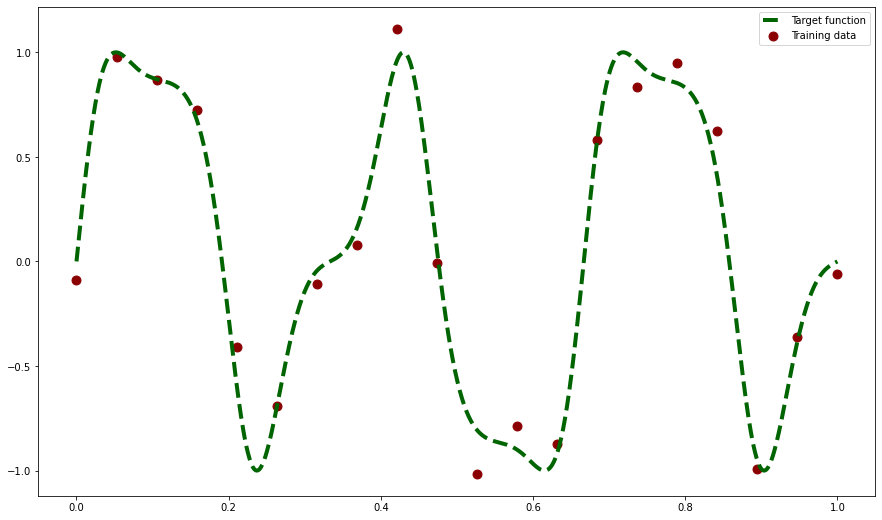

In [3]:
def sindata(n,f=3,snoise=0.1,random=True):
    if random:
        # Randomly spaced
        x = np.sort(np.random.rand(n)).reshape(-1,1)
    else:
        x = np.linspace(0,1,n).reshape(-1,1)
        
    y = np.sin(2*np.pi*x*f + 0.6*np.sin(2*np.pi*x*f*1.5 ))

    return x, y+np.random.randn(n,1)*snoise

fig, ax = plt.subplots(figsize=(15,9))

# Plot a regular line as the target function
ax.plot(*sindata(1000, snoise=0,random=False),
        linewidth=4,color="darkgreen",label="Target function",linestyle="--")

# Draw noisy data points from the trajectory above
ntrain=20
xtrain, ytrain = sindata(ntrain,snoise=.1,random=False)

ax.scatter(xtrain, ytrain, s=80,c="darkred",label="Training data")
ax.legend();

In [4]:
def my_gaussian_kernel(X1, X2, gamma):
    """ Applies a RBF kernel of parameter gamma to two inputs datasets
        Given
            X1: (N,1) ndarray
            X2: (M,1) ndarray
        Returns
            (N,M) ndarray
    """
    N = X1.shape[0]
    M = X2.shape[0]
    K = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            dis = X1[i, 0]- X2[j, 0]
            K[i][j] = np.exp(-dis**2*gamma)
    return K

In [5]:
# k : NxM, N = 20, M = 1000
# xtrain: Nx1, xtest: Mx1

In [6]:
# Test data
xtest = np.linspace(0,1,1000).reshape(-1,1)
ntrain=20
xtrain, ytrain = sindata(ntrain,snoise=.1,random=False)

In [7]:
def prepare_posterior(xtrain, xtest, ytrain, gamma):
    k = my_gaussian_kernel(xtrain, xtest, gamma)
    c = my_gaussian_kernel(xtest, xtest, gamma)
    kN = my_gaussian_kernel(xtrain, xtrain, gamma)
    inv = np.linalg.inv(kN)
    return k, c, kN, inv

In [8]:
def get_posterior(xtrain, xtest, ytrain, gamma):
    k, c, kN, inv = prepare_posterior(xtrain, xtest, ytrain, gamma)
    mu = (k.transpose() @ inv @ ytrain)
    mu = mu.reshape(1000, )
    cov = c - (k.transpose() @ inv @ k)
    sigma = np.array([cov[i][i] for i in range(1000)])
    # some of the sigma maybe negative with very small abs
    sigma = np.sqrt(np.abs(sigma))
    return mu, cov, sigma

In [9]:
mu, cov, sigma = get_posterior(xtrain, xtest, ytrain, gamma=200)

In [10]:
z = np.random.multivariate_normal(mean=mu, cov=cov, size=5).T

In [11]:
def plot_GP(xtest, mu, sigma, z, far=0):
    ig, ax = plt.subplots(figsize=(10,6), dpi=300)

    # Plot a regular line as the target function
    if(far==0):
        ax.plot(*sindata(1000, snoise=0,random=False),
            linewidth=4,color="darkgreen",label="Target function",linestyle="--")
    if(far==1):
        ax.plot(*sindata_new(1000, snoise=0,random=False),
            linewidth=4,color="darkgreen",label="Target function",linestyle="--")
        
    # Draw noisy data points (training data)
    ax.scatter(xtrain, ytrain, s=80,c="darkred",label="Training data")
    # Draw the posterior mean
    ax.plot(xtest, mu, linewidth=3, c="black", label = "mean")
    # Draw the 95% CI range
    ax.fill_between(xtest.reshape(1000, ), mu-2*sigma, mu+2*sigma, color='black', alpha=0.1, label="95% CI")
    # Draw the random samples
    ax.plot(xtest, z, linewidth = 0.8, color='black')
    # Set the lagend of the samples
    ax.plot([], [],color='black', label="samples")
    ax.legend();


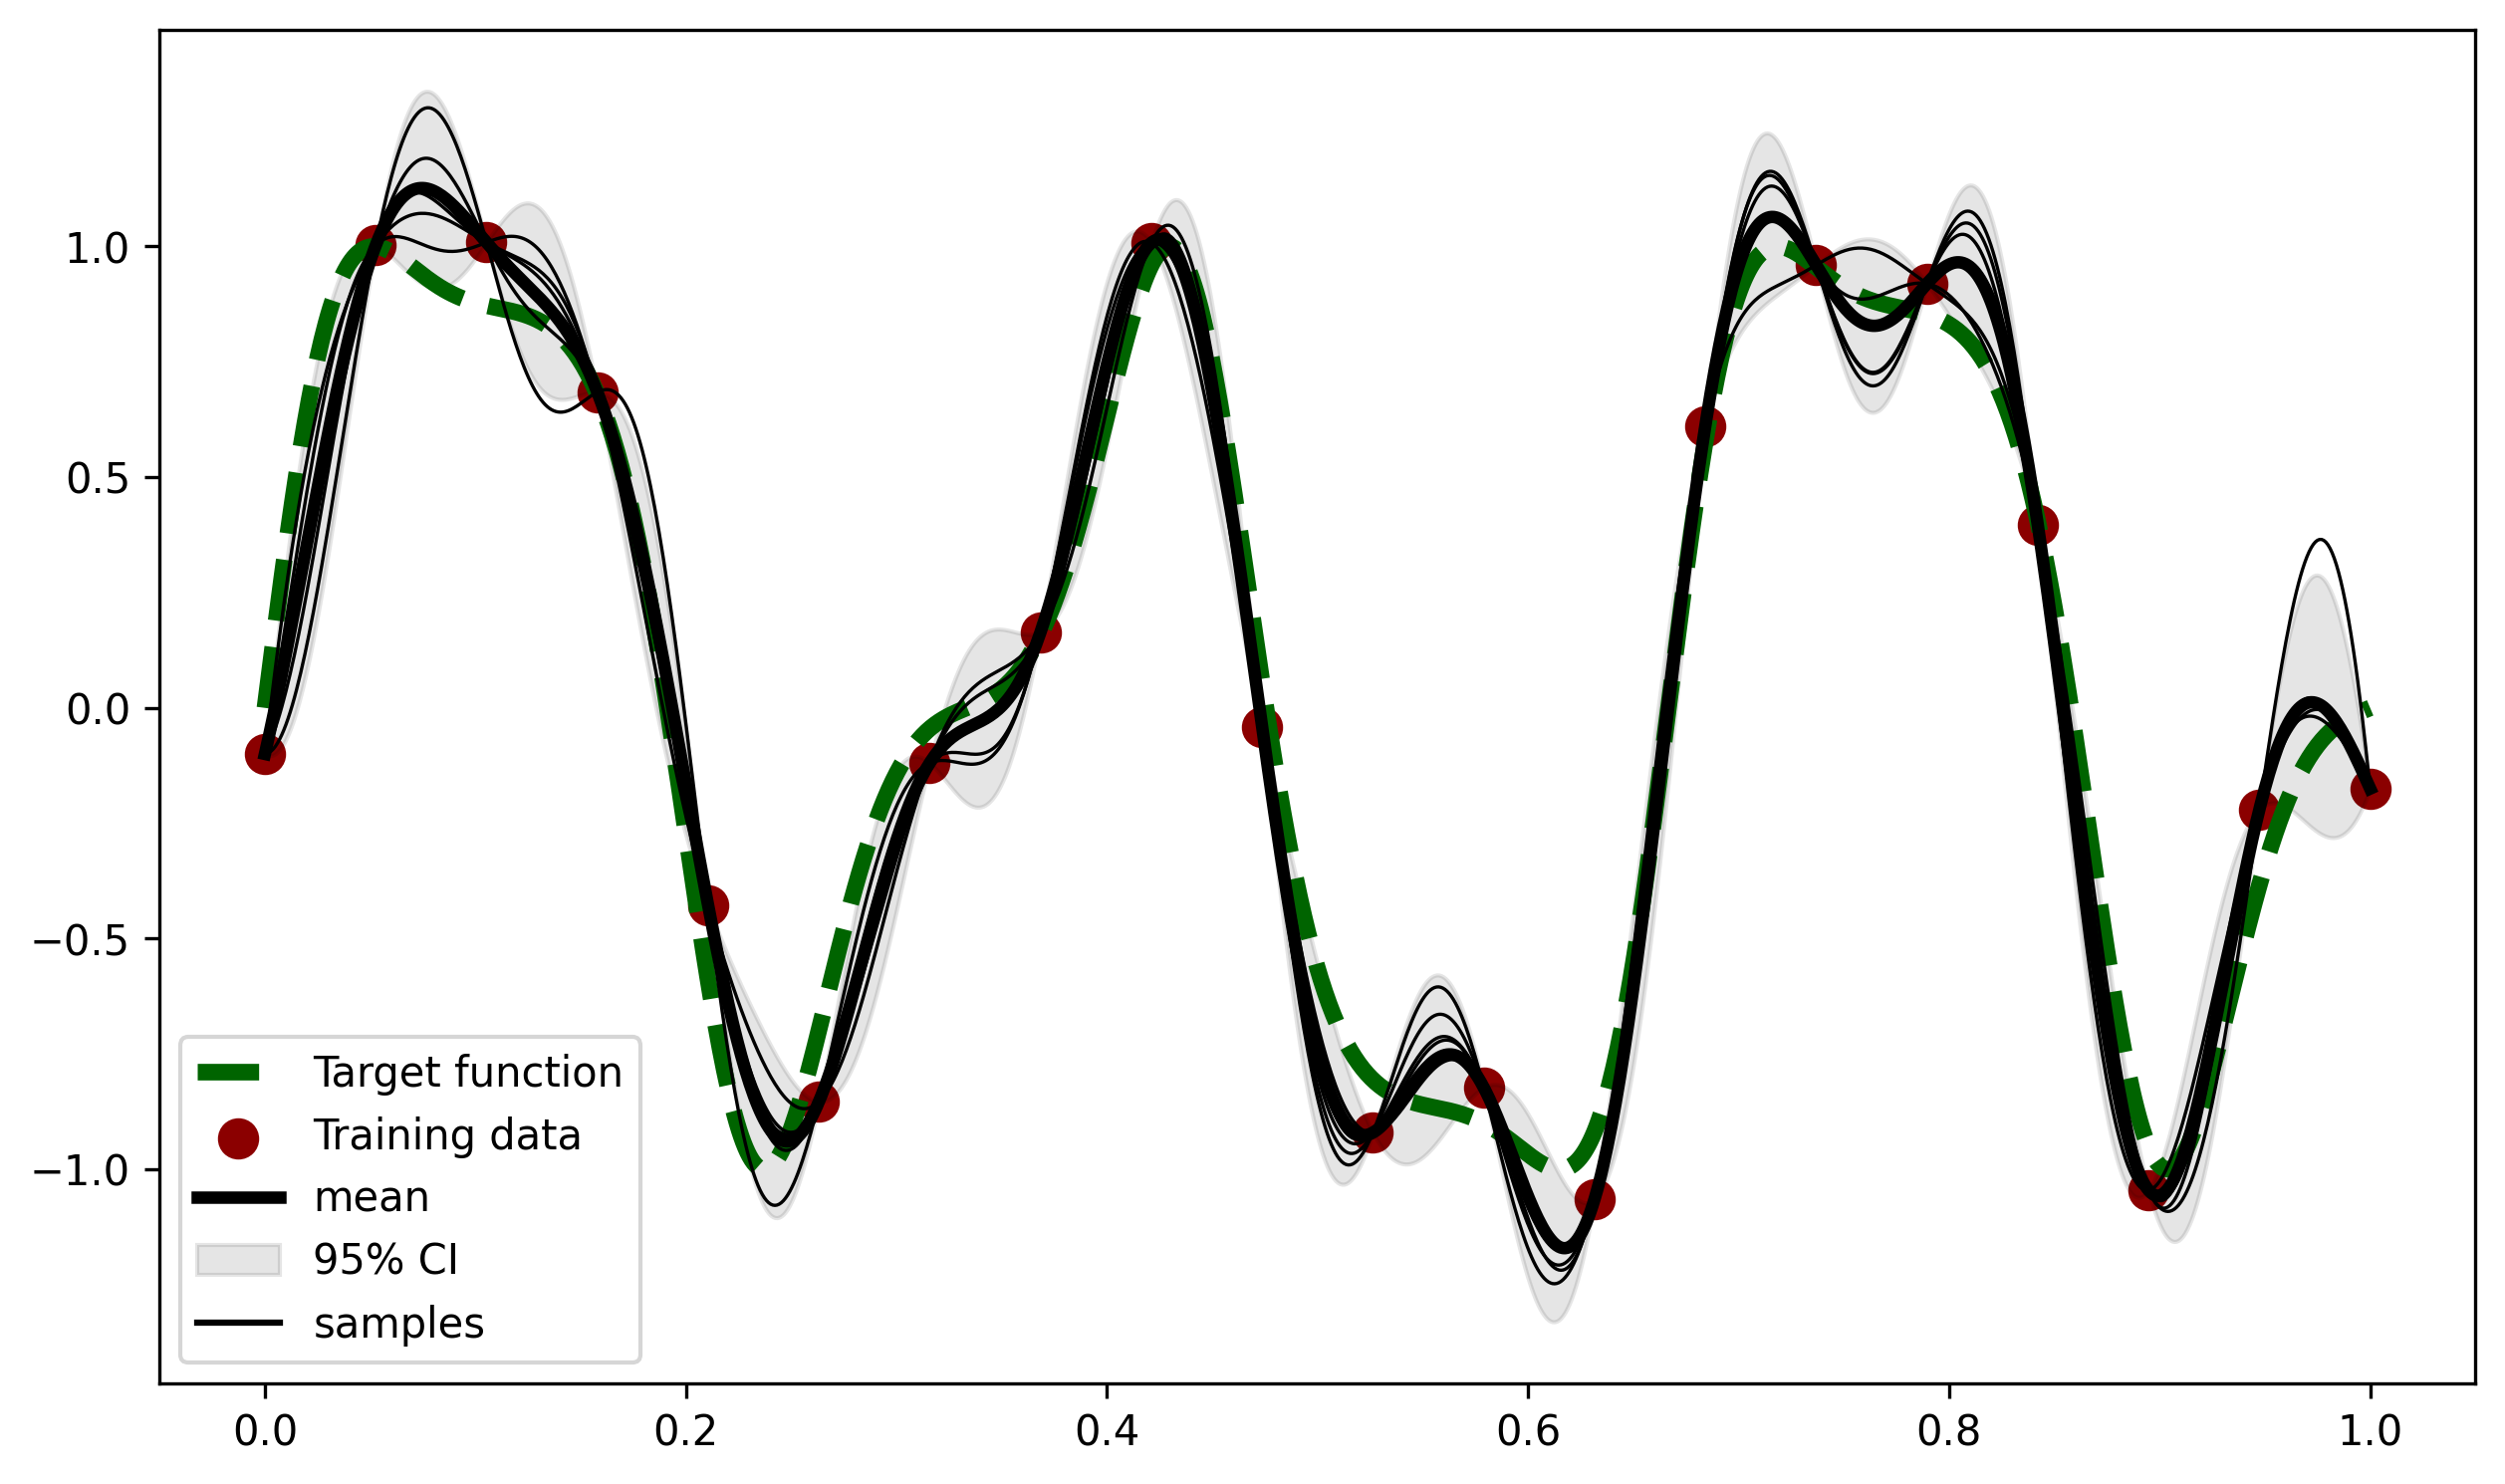

In [12]:
plot_GP(xtest,  mu, sigma, z)

In [ ]:
xtest, ytest = sindata(1000, snoise=0,random=False)
ytest = np.array(ytest).reshape(1000, )

In [ ]:
def get_mse_gp(xtrain, xtest, ytrain, gamma):
    k, c, kN, inv = prepare_posterior(xtrain, xtest, ytrain, gamma)
    mu = (k.transpose() @ inv @ ytrain)
    mu = mu.reshape(1000, )
    return ((ytest - mu)**2).mean()

In [ ]:
gamma_list = []
mse_with_gamma = []
for gamma in range(40, 400, 20):
    gamma_list.append(gamma)
    mse = get_mse_gp(xtrain, xtest, ytrain, gamma)
    mse_with_gamma.append(mse)

In [ ]:
def plot_metrics(gamma, metrics, xlabel, ylabel):
    plt.figure(figsize=(8, 5), dpi=300)
    plt.scatter(gamma, metrics)
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
#     plt.show()